## Cats vs. Dogs Classification

### NeuroWorkshop

В этом задании наша цель - научиться различать на фотографиях кошек и собак. Будем использовать [вот этот](https://www.kaggle.com/tongpython/cat-and-dog) датасет с Kaggle. 

## Подготовка данных

Первым делом загрузим датасет, для этого установим утилиту для работы с kaggle API из командной строки:

In [1]:
api_token = {"username":"shwars","key":"b7a0587f89803147992d2ba333927e3c"}

import sys
import json

!{sys.executable} -m pip install kaggle

!mkdir ~/.kaggle
with open('kaggle.json', 'w') as file:
    json.dump(api_token, file)
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

    100% |████████████████████████████████| 61kB 4.7MB/s 
    100% |████████████████████████████████| 245kB 13.3MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


Теперь собственно загружаем датасет: это может занять некоторое время!

In [2]:
!kaggle datasets download -d tongpython/cat-and-dog

 97% 211M/217M [00:04<00:00, 25.5MB/s]
100% 217M/217M [00:04<00:00, 51.4MB/s]


Скачанный датасет представляет собой один .zip-файл, распакуем его для последующего использования:

In [3]:
!unzip cat-and-dog.zip
!rm cat-and-dog.zip
!unzip -q test_set.zip
!unzip -q training_set.zip
!rm *.zip

Archive:  cat-and-dog.zip
  inflating: training_set.zip        
  inflating: test_set.zip            


In [4]:
!ls

sample_data  test_set  training_set


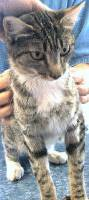

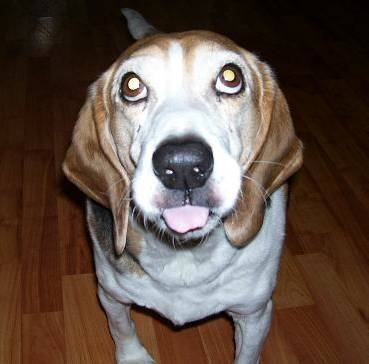

In [13]:
from IPython.display import display, Image
import matplotlib.pyplot as plt
import os
def get_file(set_name,class_name):
  x = os.listdir(os.path.join(set_name,class_name))[0]
  return os.path.join(set_name,class_name,x)
display(Image(get_file('training_set','cats')))
display(Image(get_file('training_set','dogs')))

## Работа с изображениями в Kaggle

Kaggle позволяет автоматически читать множества изображений из папки на диске, при этом производя с ними некоторые предварительные манипуляции (например, масштабирование до нужного размера). Для этого используются следующий механизм:

 * `keras.preprocessing.image.ImageDataGenerator` - задаёт дополнительные (помимо масштабирования) преобразования, которые необходимо совершить с изображением
 * У `ImageDataGenerator` есть набор методов `flow`, которые позволяют ему применяться к различным коллекциям изображений: к массиву `numpy`, к директории и т.д. Для работы с директорией используют `flow_from_directory`
 * Механизм `flow` отвечает за масштабирование (мы передаём ему требуемый размер изображений), а также распознаёт названия классов (если каждый класс лежит в своей директории)
 * Механизм `flow` также зацикливает последовательность данных и разбивает их на *minibatches*
 * Результат является генератором, который можно подавать на вход методу `model.train_generator` для тренировки сети
 

In [5]:
import keras

img_size = (128,128)
batch_size = 32

data_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_flow = data_gen.flow_from_directory('training_set',target_size=img_size,batch_size=batch_size,class_mode='binary')
test_flow = data_gen.flow_from_directory('test_set',target_size=img_size,batch_size=batch_size,class_mode='binary')

Using TensorFlow backend.


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [0]:
train_images = 8000
test_images = 2000


## Описываем архитектуру сети

Для распознавания изображений будем использовать свёрточную нейросеть

In [20]:
from keras.layers import *
model = keras.models.Sequential()

# TODO: здесь будет код для создания нейросети
# Выходной слой должен содержать 1 нейрон, поскольку мы используем class_mode=binary
# Размерность входного слоя = (128,128,3)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)             0         
__________

## Обучаем модель

Поскольку генератор зациклен, мы указываем количество шагов обучения в каждую эпоху и для тестовых данных. Чтобы пройти по всем входным данным, необходимо указать `steps_per_epoch = train_images // batch_size`. В нашем случае возьмём значение чуть меньшее, чтобы посмотреть на процесс обучения с меньшей гранулярностью.


In [21]:
hist = model.fit_generator(train_flow,
  steps_per_epoch = 100,
  epochs = 7,
  validation_data = test_flow,
  validation_steps = 10)

Epoch 1/7
100/100 [==============================] - 13s 134ms/step - loss: 0.6748 - acc: 0.5619 - val_loss: 0.7609 - val_acc: 0.5281
Epoch 2/7
100/100 [==============================] - 13s 127ms/step - loss: 0.6077 - acc: 0.6597 - val_loss: 0.6362 - val_acc: 0.6438
Epoch 3/7
100/100 [==============================] - 12s 123ms/step - loss: 0.5863 - acc: 0.6986 - val_loss: 0.6533 - val_acc: 0.6438
Epoch 4/7
100/100 [==============================] - 13s 126ms/step - loss: 0.5569 - acc: 0.7119 - val_loss: 0.5354 - val_acc: 0.7125
Epoch 5/7
100/100 [==============================] - 12s 121ms/step - loss: 0.5470 - acc: 0.7297 - val_loss: 0.5400 - val_acc: 0.7375
Epoch 6/7
100/100 [==============================] - 12s 123ms/step - loss: 0.4825 - acc: 0.7659 - val_loss: 0.4488 - val_acc: 0.7695
Epoch 7/7
100/100 [==============================] - 12s 123ms/step - loss: 0.4912 - acc: 0.7691 - val_loss: 0.4745 - val_acc: 0.7812


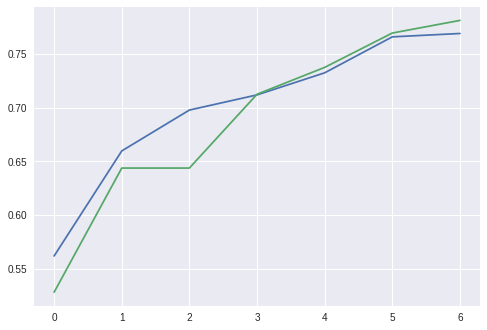

In [22]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## Проверяем работу сети на произвольном изображении

Проверим работу сети на изображении из интернет.

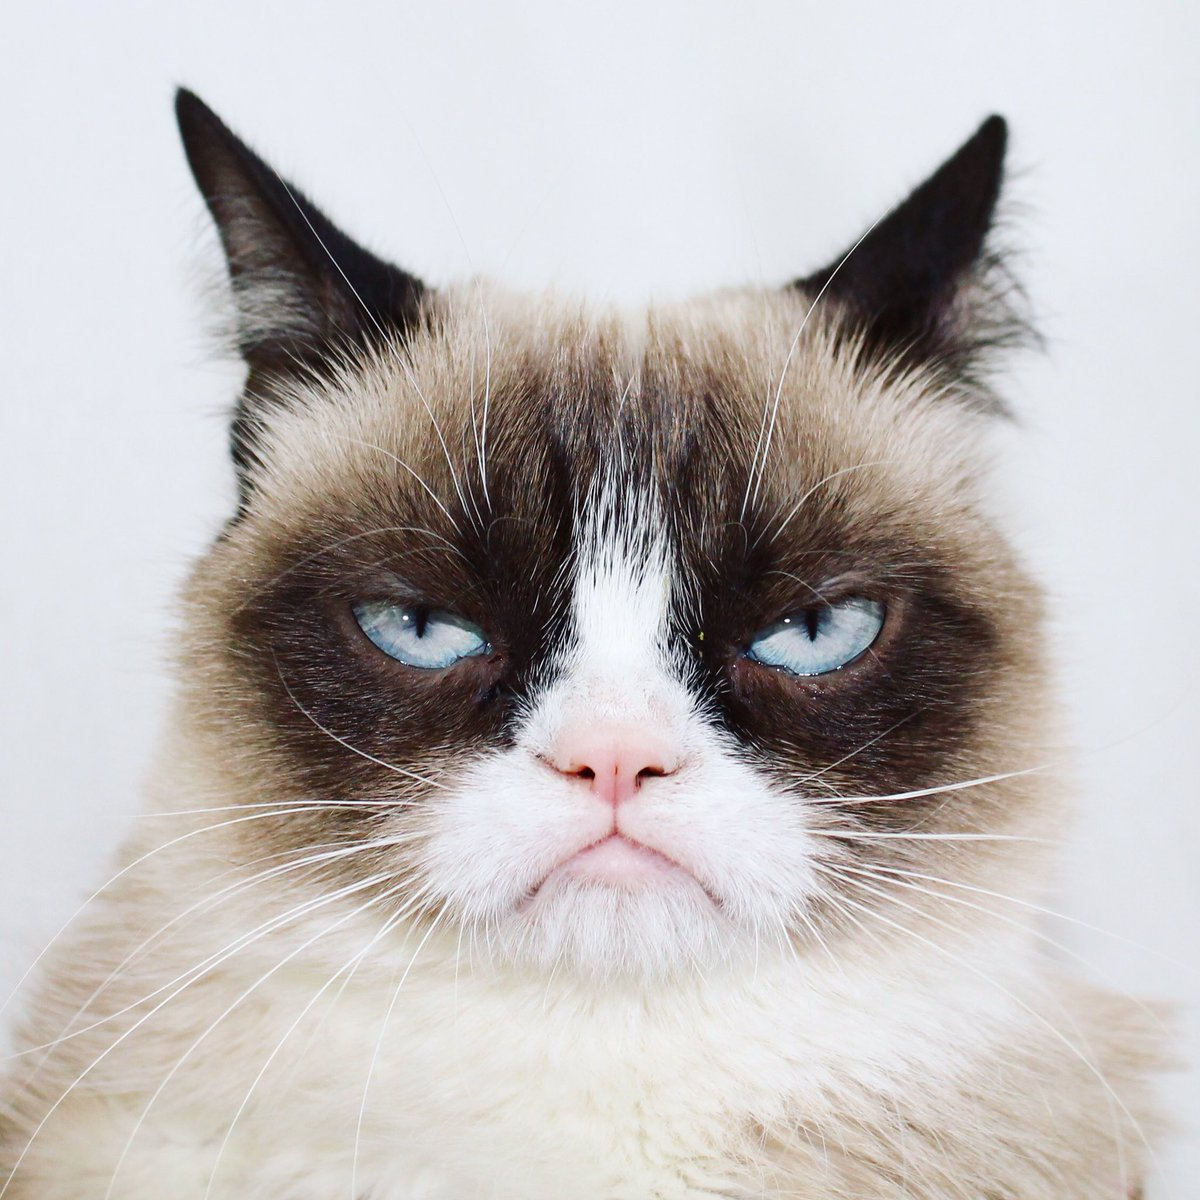

In [27]:
cat_img = 'https://pbs.twimg.com/media/CsW0pmxUsAAuvEN.jpg'
display(Image(cat_img))

Перед подачей изобажения на вход сети необходимо его масштабировать (и если мы делали какие-то шаги в качестве предобработки - проделать их тоже). Обычно масштабирование имеет смысл делать с сохранением пропорций.

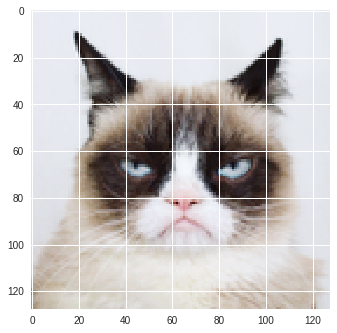

In [58]:
import numpy as np
import PIL,requests,io
from PIL import ImageOps

def load_img(url,size=img_size):
  response = requests.get(url)
  img = PIL.Image.open(io.BytesIO(response.content))
  img.thumbnail(size,PIL.Image.ANTIALIAS)
  delta_w = size[0] - img.size[0]
  delta_h = size[1] - img.size[1]
  padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
  img = PIL.ImageOps.expand(img, padding)
  return img

plt.imshow(load_img(cat_img))

In [0]:
# TODO: Добавьте код для применения нейронной сети к изображению
# Важно: на вход сети подаётся тензор, содержащий (возможно) несколько изображений.
#   Поэтому нужно увеличить размерность тензора с помощью np.expand_dims
# Возможно, вам потребуется преобразовать изображение из PIL Image в numpy-array.
#   Для этого может быть полезна функция keras.preprocessing.image.img_to_array(..)

In [0]:
dog_img = 'https://www.morrisanimalinn.com/wp-content/gallery/grooming-gallery/Dog-grooming.jpg'

# TODO: Проверьте, работает ли предсказание для собак

## Пробуем использовать предобученную сеть

`keras` позволяет легко использовать предобученные на стандартных наборах данных сети. Это позволяет запустить классификатор для стандартных классов несколькими строчками кода. Например, загрузим архитектуру `VGG-19`, обученную на **ImageNet**:

In [63]:
vgg = keras.applications.vgg19.VGG19(weights='imagenet')
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Модель расчитана на изображения размером $224\times224$. Размерность выходного вектора равно $1000$ (количество классов), для определения номера предсказанного класса можно использовать функцию `argmax`:

In [62]:
# TODO: res = vgg.predict(...)
# res.argmax()

283

К счастью, `keras.applications` содержит также для каждого класса функцию `decode_predictions`, которая позволяет получить имена предсказанных классов для конкретной архитектуры. Также по хорошему следует перед подачай изображения нейросети пропускать его через функцию  `preprocess_input` для соответствующей архитектуры.

In [64]:
keras.applications.vgg19.decode_predictions(res)

40960/35363 [==================================] - 0s 2us/step


[[('n02123394', 'Persian_cat', 0.9437201),
  ('n02123045', 'tabby', 0.02127012),
  ('n02123597', 'Siamese_cat', 0.008975401),
  ('n02127052', 'lynx', 0.006260971),
  ('n02124075', 'Egyptian_cat', 0.003448508)]]

In [0]:
# Сделайте такое предсказание для ещё нескольких изображений из интернет